<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using arterial blood pressure waveform

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the arterial blood pressure waveform (ART) in the VitalDB dataset.

## Required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

!pip install vitaldb
import vitaldb

## Case Selection

In [2]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("heart")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("cardiac")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto")]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3337 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

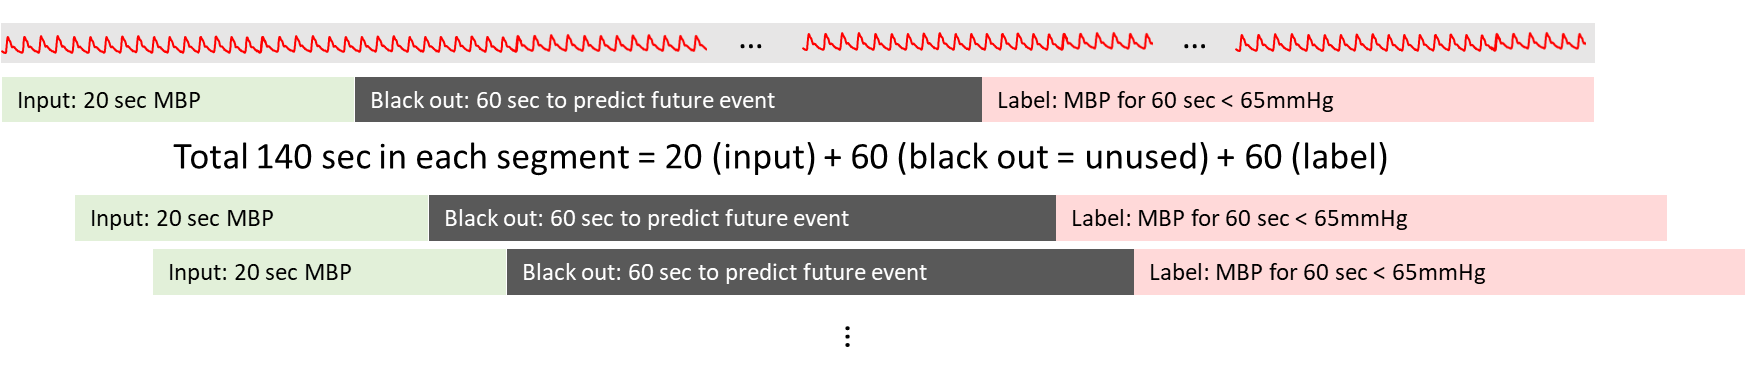

In [3]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    # input: 20sec - blackout: 1min - label: 1min
    case_sample = 0
    case_event = 0
    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        n = 2 * SRATE  # 2 sec moving avg
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]  

print(x.shape)
print(y.shape)

loading 4964...655 samples 0 (0.0 %) events
loading 3317...1568 samples 9 (0.6 %) events
loading 2282...465 samples 23 (4.9 %) events
loading 2435...745 samples 0 (0.0 %) events
loading 296...995 samples 0 (0.0 %) events
loading 954...615 samples 28 (4.6 %) events
loading 6058...1788 samples 7 (0.4 %) events
loading 4128...770 samples 12 (1.6 %) events
loading 4109...254 samples 22 (8.7 %) events
loading 1823...751 samples 0 (0.0 %) events
loading 1486...2309 samples 7 (0.3 %) events
loading 4591...1144 samples 149 (13.0 %) events
loading 565...no sample
loading 1837...353 samples 2 (0.6 %) events
loading 6174...695 samples 0 (0.0 %) events
loading 2779...475 samples 0 (0.0 %) events
loading 3514...854 samples 211 (24.7 %) events
loading 3428...1219 samples 164 (13.5 %) events
loading 4913...737 samples 0 (0.0 %) events
loading 636...609 samples 0 (0.0 %) events
loading 4579...673 samples 45 (6.7 %) events
loading 3646...1241 samples 2 (0.2 %) events
loading 1470...299 samples 29 (9.7 

## Splitting samples into training and testing dataset


In [4]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), \
    len(train_y_valid), sum(train_y_valid), 100 * np.mean(train_y_valid), \
    len(test_y_valid), sum(test_y_valid), 100 * np.mean(test_y_valid))
print(testname)

100cases 1ahead batchsize=256 total 137391, train 78606 (1752 events 2.2%), test 25509 (1466 events 5.7%)


## Model building and training

In [5]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# hyper parameter
CNN_LAYERS = [64] * 6

# build a model
model = Sequential()
for num_node in CNN_LAYERS:
    model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
277/277 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9565 - auc: 0.9521
Epoch 1: val_loss improved from inf to 0.05569, saving model to output/weights.hdf5
277/277 [==============================] - 40s 93ms/step - loss: 0.1848 - accuracy: 0.9565 - auc: 0.9521 - val_loss: 0.0557 - val_accuracy: 0.9835 - val_auc: 0.9859
Epoch 2/100
276/277 [============================>.] - ETA: 0s - loss: 0.1518 - accuracy: 0.9648 - auc: 0.9656
Epoch 2: val_loss improved from 0.05569 to 0.03821, saving model to output/weights.hdf5
277/277 [==============================] - 25s 89ms/step - loss: 0.1517 - accuracy: 0.9648 - auc: 0.9657 - val_loss: 0.0382 - val_accuracy: 0.9823 - val_auc: 0.9860
Epoch 3/100
276/277 [============================>.] - ETA: 0s - loss: 0.1426 - accuracy: 0.9672 - auc: 0.9697
Epoch 3: val_loss did not improve from 0.03821
277/277 [==============================] - 25s 89ms/step - loss: 0.1428 - accuracy: 0.9672 - auc: 0.9697 - val_loss: 0

9290

## Evaluation of the model performance

In [6]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_p = model.predict(test_x, BATCH_SIZE).flatten()
test_p_valid = test_p[valid_mask[test_mask]]

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_p_valid)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_p_valid)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_p_valid > thval)
acc = accuracy_score(test_y_valid, test_p_valid > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_p_valid > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

auroc=0.946, auprc=0.491 acc=0.952, F1=0.563, PPV=59.4, NPV=97.2, TN=23506, fp=537, fn=681, TP=785


## Plotting each case in the test dataset

5079	0.013587779237316135	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


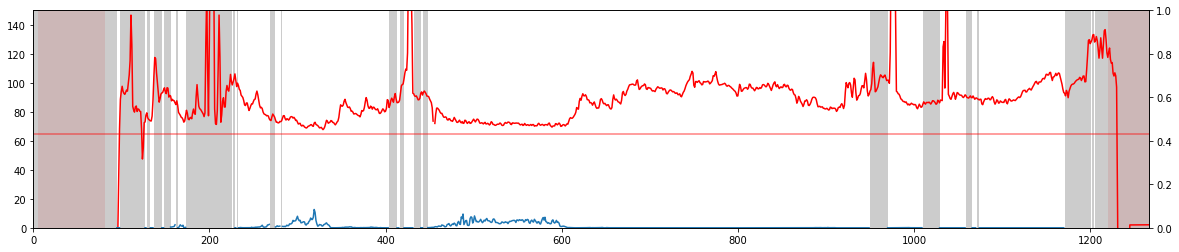

5100	0.2534394007092944	


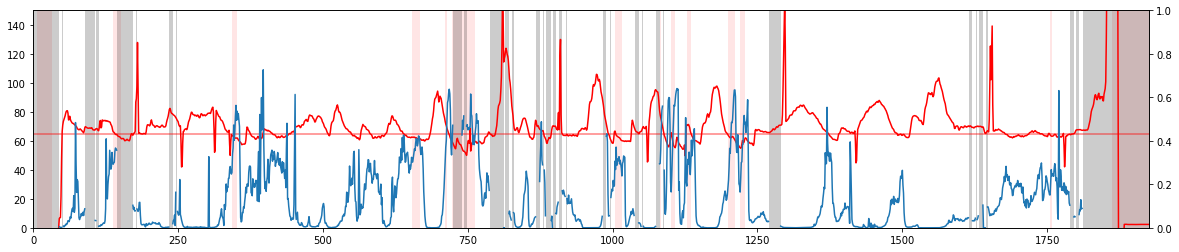

5124	0.05911421687303856	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


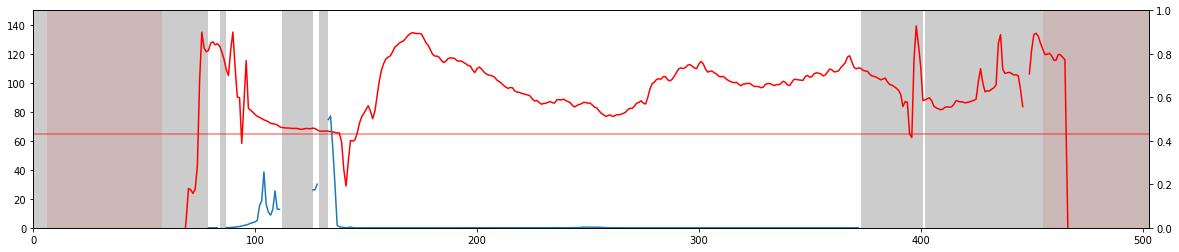

5245	0.15376173244077276	


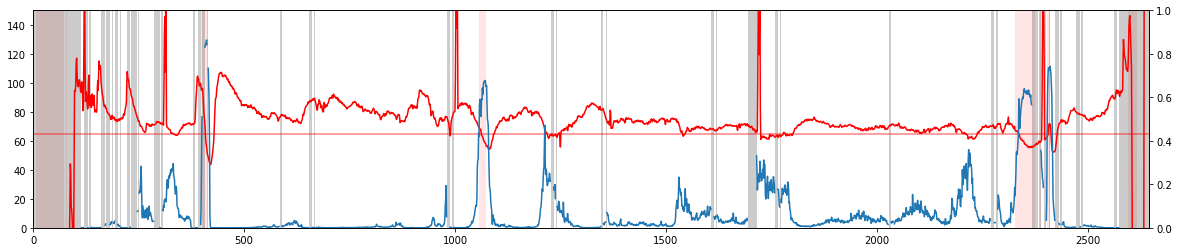

5252	0.3157022674329892	


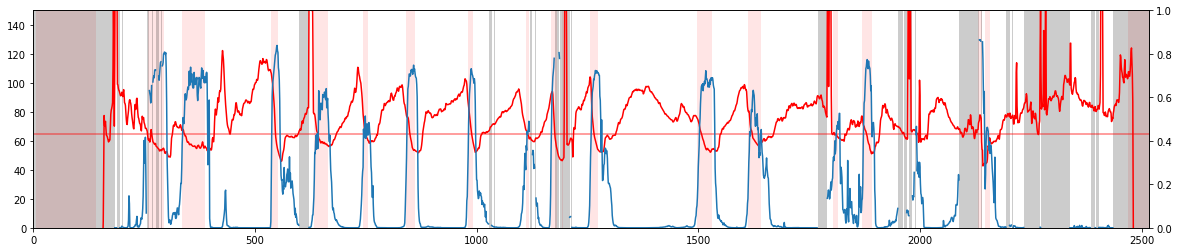

5253	0.021420478629734736	


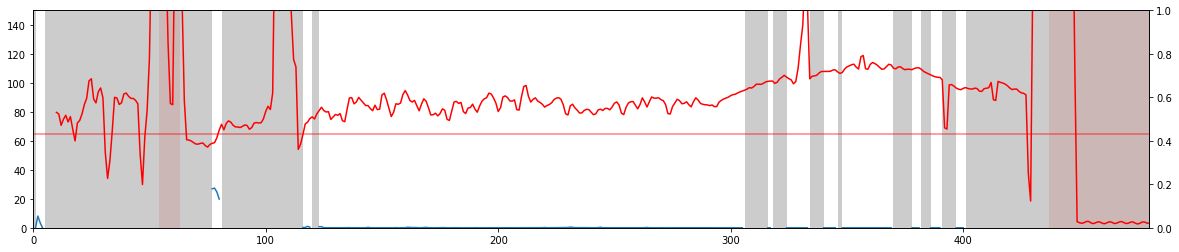

5301	0.0854490988594304	


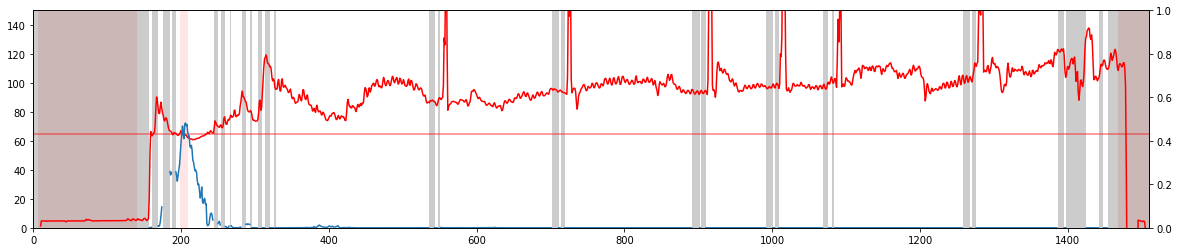

5328	0.3001996151101417	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


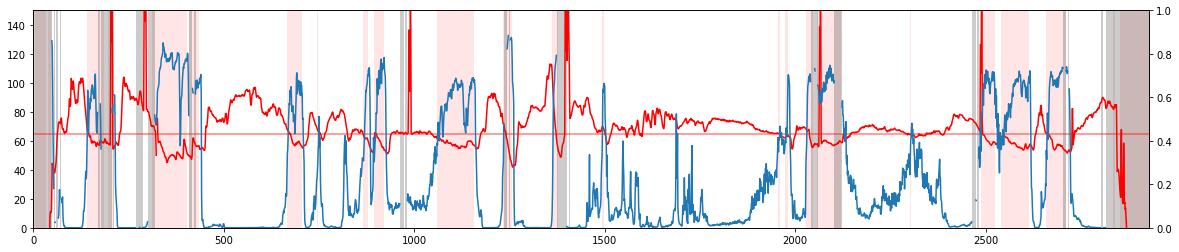

5339	0.03289634792698424	


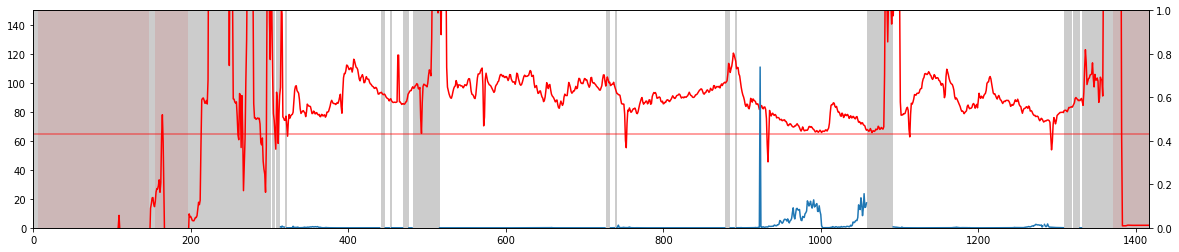

5346	0.19320134727810892	


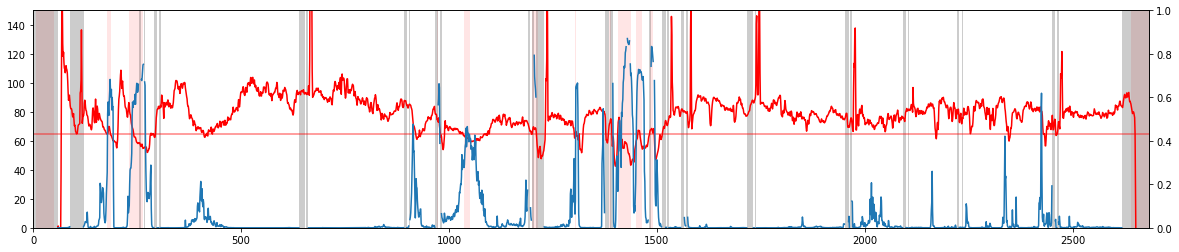

5410	0.009360017203387206	


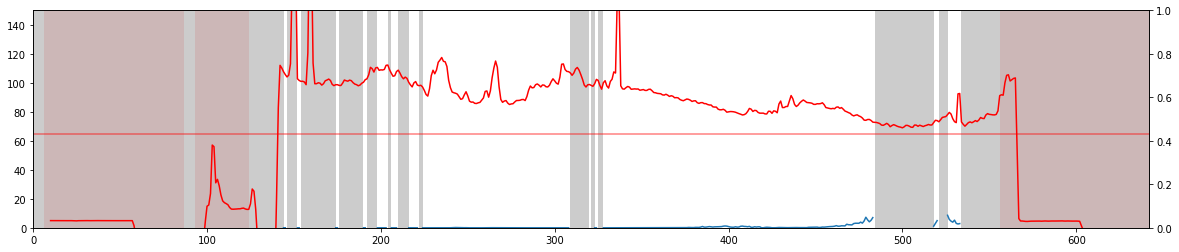

5513	0.0867217593916672	


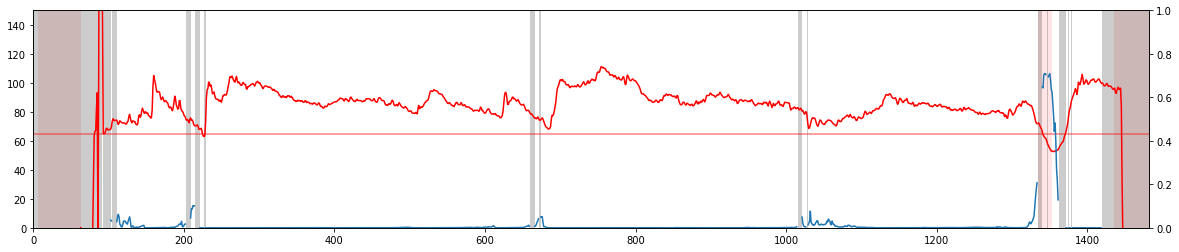

5755	0.07286438777927791	


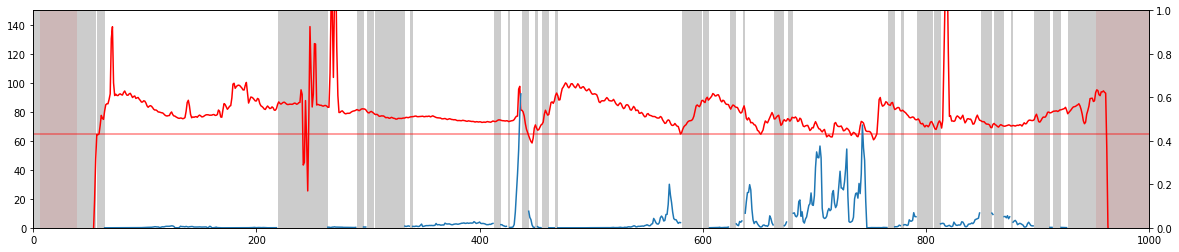

5831	0.26406002438530307	


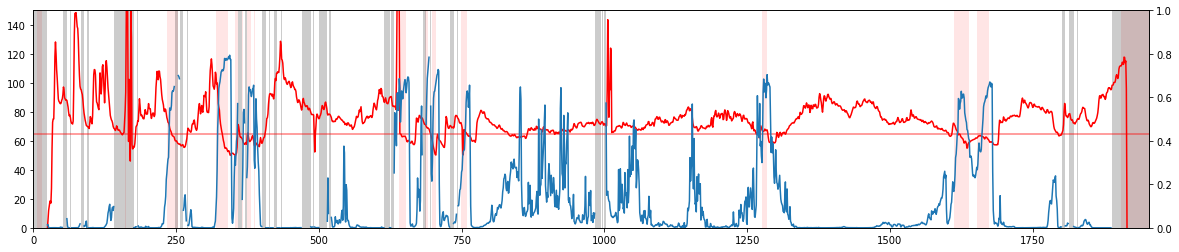

5859	0.04012224378405559	


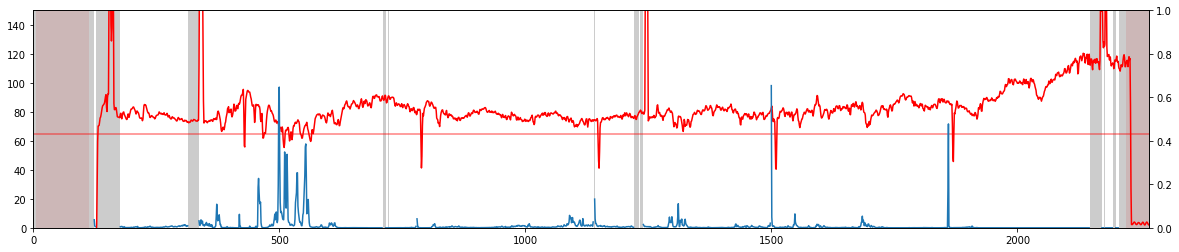

5965	0.11960672445369086	


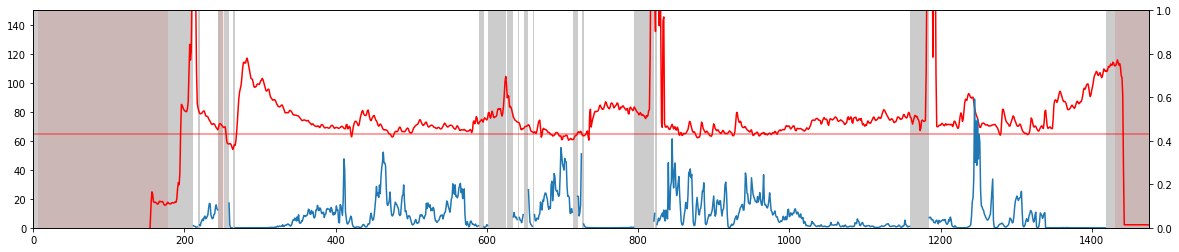

6058	0.08996750249027582	


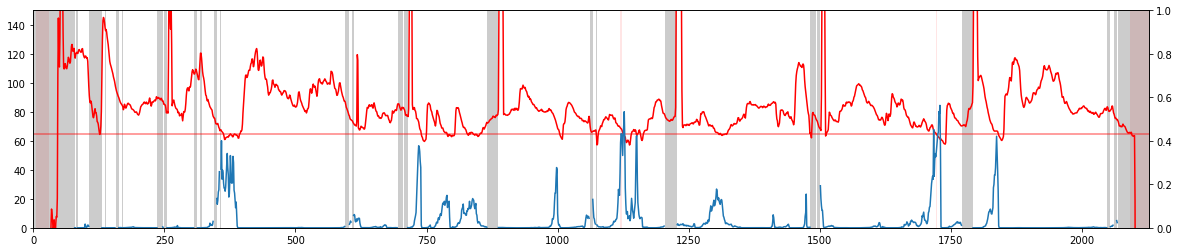

6063	0.20007611890008326	


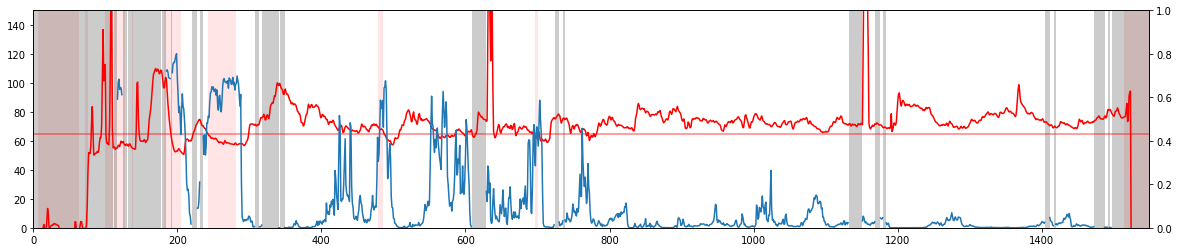

6174	0.014181821379476975	


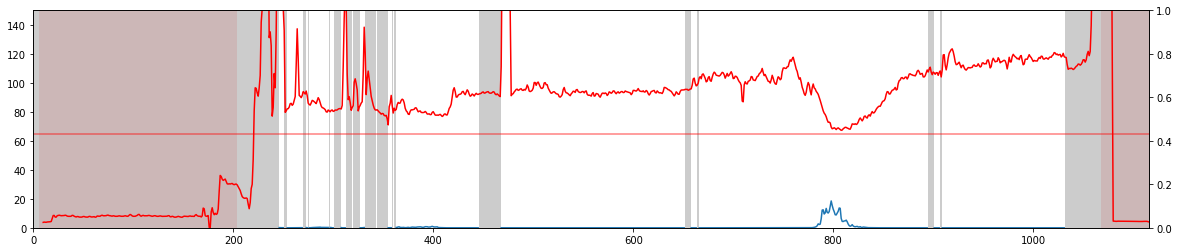

6266	0.1787493513335616	


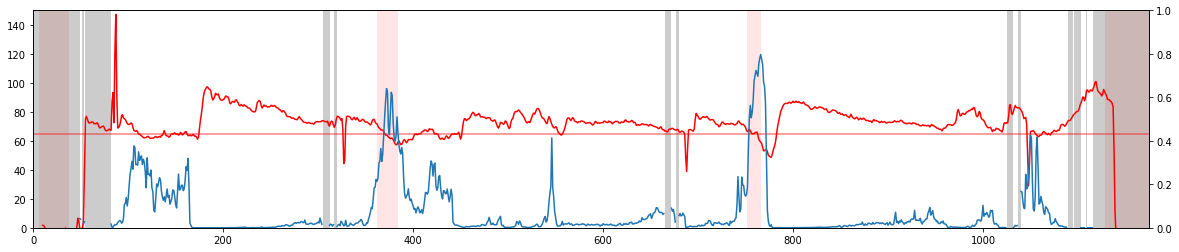

In [7]:
for caseid in caseids_test:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = test_p[case_mask]
    case_valid_mask = valid_mask[test_mask][case_mask]
    case_p[~case_valid_mask] = np.nan
    if sum(case_valid_mask) == 0:
        continue
    
    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y - case_p)) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 6, i + MINUTES_AHEAD * 6 + 1, color='r', alpha=0.1, lw=0)
        if not case_valid_mask[i]:
            ax1.axvspan(i, i + 1, color='k', alpha=0.2, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples only
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()